1

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')


file_path = 'text_doc.txt'
with open(file_path) as file:
    text = file.read()


tokens = word_tokenize(text)
stop_words = set(stopwords.words('english'))

filtered_words = [word for word in tokens if word.lower() not in stop_words]
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(token) for token in filtered_words]
stemmed_words



2

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Load data
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
           'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                   names=columns)

# Basic preprocessing
data = data.replace('?', np.nan).dropna()
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col])

# Simple binary features
data['age_high'] = (data['age'] > 60).astype(int)
data['bp_high'] = (data['trestbps'] > 140).astype(int)
data['chol_high'] = (data['chol'] > 240).astype(int)
data['target'] = (data['target'] > 0).astype(int)

# Select final features
features = ['age_high', 'bp_high', 'chol_high', 'cp', 'exang', 'target']
data = data[features].astype(int)

# Create and train model
model = BayesianNetwork([
    ('age_high', 'target'),
    ('bp_high', 'target'),
    ('chol_high', 'target'),
    ('cp', 'target'),
    ('exang', 'target')
])

model.fit(data, estimator=MaximumLikelihoodEstimator)
inference = VariableElimination(model)

# Make prediction
evidence = {
    'age_high': 0,    # age > 60
    'bp_high': 1,     # blood pressure > 140
    'chol_high': 1,   # cholesterol > 240
    'cp': 1 ,          # chest pain type
    'exang': 0       # exercise induced angina
}

result = inference.query(variables=['target'], evidence=evidence)
print(f"Probability of Heart Disease: {result.values[1]:.2%}")

# Print data distribution
print("\nData Distribution:")
for col in features:
    print(f"\n{col}:")
    print(data[col].value_counts().sort_index())

3

In [ ]:

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram,linkage

iris = load_iris()
X = iris.data

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled[:2]

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)
X_pca[:2]


Z = linkage(X_pca,'ward')
plt.figure(figsize=(10,6))
dendrogram(Z)
plt.show()

clustering = AgglomerativeClustering(n_clusters=3)
clustering.fit(X_pca)

plt.scatter(X_pca[:,0],X_pca[:,1],c=clustering.labels_,cmap='rainbow')



4

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import matplotlib.pyplot as plt

def get_links(url):
    try:
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.content, 'html.parser')
        return {urljoin(url, a['href']) for a in soup.find_all('a', href=True) 
                if urljoin(url, a['href']).startswith(url)}
    except:
        return set()

# Websites to analyze
websites = [
    'https://www.ted.com',
    'https://www.goodreads.com',
    'https://www.airbnb.com',
    'https://www.khanacademy.org'
]

# Get links for each website
link_map = {url: get_links(url) for url in websites}

# Calculate PageRank
d = 0.85  # damping factor
pagerank = {url: 1/len(websites) for url in websites}

# Run PageRank algorithm for 20 iterations
for _ in range(20):
    new_rank = {}
    for page in websites:
        # Calculate incoming PageRank
        incoming_pr = sum(pagerank[src] / len(links) 
                         for src, links in link_map.items() 
                         if page in links and links)
        # Update PageRank
        new_rank[page] = (1 - d) / len(websites) + d * incoming_pr
    pagerank = new_rank

# Normalize scores
total = sum(pagerank.values())
pagerank = {url: score/total for url, score in pagerank.items()}

# Plot results
plt.figure(figsize=(10, 5))
sorted_pr = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
sites, scores = zip(*sorted_pr)
plt.barh([site.replace('https://www.', '').replace('.com', '').replace('.org', '') 
          for site in sites], scores)
plt.xlabel('PageRank Score')
plt.title('Website PageRank Scores')
plt.tight_layout()
plt.show()

# Print scores
for url, score in sorted_pr:
    print(f'{url}: {score:.6f}')

In [ ]:
import numpy as np
adj_matrix = np.array([[0,1,1,0],
                       [0,0,1,1],
                       [1,0,0,1],
                       [0,0,1,0]])
n = len(adj_matrix)
transition_matrix = np.zeros((n,n))

for i in range(n):
    row_sum = np.sum(adj_matrix[i])

    if row_sum == 0:
        transition_matrix[i] = 1 / n
    else:
        transition_matrix[i] = adj_matrix[i] / row_sum


damping_factor = 0.85
num_iterations = 100
tolerance = 1e-6

page_rank = np.ones(n) / n

for i in range(num_iterations):
    new_page_rank = (1-damping_factor) / n + damping_factor * transition_matrix.T @ page_rank

    if np.linalg.norm(new_page_rank - page_rank,ord=1) < tolerance:
        print('converged')
        break

    page_rank = new_page_rank

5

In [ ]:
import requests
from bs4 import BeautifulSoup

# Base URL of the e-commerce site with pagination structure
base_url = 'http://books.toscrape.com/catalogue/page-{}.html'

# Function to scrape product data from a single page
def scrape_books(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Ensure the request was successful
    soup = BeautifulSoup(response.content, 'html.parser')
    
    books = []
    for product in soup.select('article.product_pod'):
        title = product.h3.a['title']
        price = product.select_one('.price_color').get_text(strip=True)
        link = product.h3.a['href']
        full_link = requests.compat.urljoin(url, link)  # Join relative link with base URL

        books.append({
            'title': title,
            'price': price,
            'link': full_link
        })
    return books

# Loop through multiple pages
all_books = []
for page_num in range(1, 6):  # Adjust the range based on the number of pages
    url = base_url.format(page_num)
    try:
        books_data = scrape_books(url)
        if not books_data:  # Stop if no books are found on the page (end of pagination)
            break
        all_books.extend(books_data)
        print(f"Page {page_num} scraped successfully.")
    except requests.HTTPError as e:
        print(f"Failed to scrape page {page_num}: {e}")
        break

# Print all book data collected
for book in all_books:
    print(f"Title: {book['title']}")
    print(f"Price: {book['price']}")
    print(f"Link: {book['link']}")
    print('-' * 40)


b1

In [ ]:
with open(fasta_file) as file:
    lines = file.readlines()
    print(lines)

sequence = ''

with open(fasta_file) as file:
    lines = file.readlines()
    sequence = ''.join(line.strip() for line in lines[1:]).upper()


a_count = sequence.count('A')
t_count = sequence.count('T')

total_count = len(sequence)

at_percent = ((a_count + t_count) * 100) / total_count 

g_count = sequence.count('G')
c_count = sequence.count('C')

gc_percent = ((g_count + c_count)*100)/total_count

at_percent / gc_percent

start_codon = 'ATG'
# stop_codon = 'TAA'
stop_codons = ['TAA', 'TAG', 'TGA']

start_index = sequence.find(start_codon)

coding_region = []

while start_index != -1:

    for stop_codon in stop_codons:
        stop_index = sequence.find(stop_codon,start_index+3)

        if stop_index != -1 and (stop_index - start_index) % 3 == 0:
            coding_seq = sequence[start_index:stop_index+3]
            coding_region.append(coding_seq)
            break

    start_index = sequence.find(start_codon,start_index+1)


motif = 'TATAA'

start_index = sequence.find(motif)

while start_index != -1:

    print(f"Motif '{motif}' found at positions {start_index}")

    start_index = sequence.find(motif,start_index+1)

b2

In [ ]:
# Load required libraries
if (!require("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install(c("DESeq2", "pasilla"))

library(DESeq2)
library(pasilla)
library(ggplot2)

# Load count and metadata
cts <- as.matrix(read.csv(system.file("extdata", "pasilla_gene_counts.tsv", package="pasilla"), sep="\t", row.names="gene_id"))
coldata <- read.csv(system.file("extdata", "pasilla_sample_annotation.csv", package="pasilla"), row.names=1)
coldata$condition <- factor(coldata$condition)
rownames(coldata) <- sub("fb", "", rownames(coldata))
cts <- cts[, rownames(coldata)]  # Ensure matching order

# Differential Expression Analysis
dds <- DESeqDataSetFromMatrix(countData=cts, colData=coldata, design=~condition)
dds <- DESeq(dds)
res <- results(dds)
write.csv(res, "DESeq_Analysis.csv")

# Load results and label differential expression
df <- read.csv("DESeq_Analysis.csv")
df$Diffexpressed <- ifelse(df$log2FoldChange > 0.1 & df$pvalue < 0.05, "UP", 
                           ifelse(df$log2FoldChange < -0.1 & df$pvalue < 0.05, "DOWN", "NO"))

# Plot volcano plot
ggplot(df, aes(x=log2FoldChange, y=-log10(pvalue), color=Diffexpressed)) +
  geom_vline(xintercept=c(-1, 1), col="black", linetype="dashed") +
  geom_vline(xintercept=c(-0.5, 0.5), col="green", linetype="dashed") +
  geom_hline(yintercept=-log10(0.00003), col="red", linetype="dashed") +
  geom_hline(yintercept=-log10(0.05), col="black", linetype="dashed") +
  geom_point(size=2) +
  theme_minimal() +
  scale_color_manual(values=c("DOWN"="#00AFBB", "NO"="grey", "UP"="pink")) +
  labs(title="Volcano Plot", x="log2(Fold Change)", y="-log10(p-value)")

# Export upregulated and downregulated gene lists
write(rownames(df[df$Diffexpressed == "UP", ]), "upreg.txt")
write(rownames(df[df$Diffexpressed == "DOWN", ]), "downreg.txt")




b4

/tmp/ipykernel_15203/1242700912.py:7: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('METABRIC_RNA_Mutation.csv')


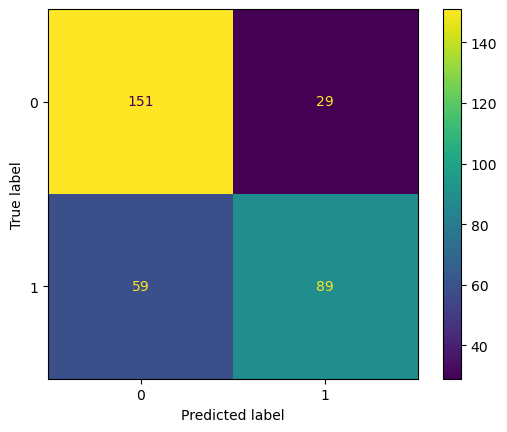

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,classification_report,accuracy_score,f1_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('METABRIC_RNA_Mutation.csv')
df.head()
df.dropna(inplace=True)
df_exp = df.iloc[:,30:519].join(df['overall_survival'],how='inner')
target_column = 'overall_survival'

X = df_exp.drop(columns=target_column)
y = df_exp['overall_survival']
X = pd.get_dummies(X,drop_first=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train,y_train)

y_pred = random_forest_model.predict(X_test)
accuracy_score(y_test,y_pred)
f1_score(y_test,y_pred)
svc_model = SVC()
svc_model.fit(X_train,y_train)

y_pred_svc = svc_model.predict(X_test)
accuracy_score(y_test,y_pred_svc)

f1_score(y_test,y_pred_svc)

cm = confusion_matrix(y_test,y_pred_svc)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(cm)
disp.plot()